# Comp01: Text Feature Engineering
---

111062117 黃祥陞


In [54]:
import pandas as pd

df_train = pd.read_csv('./dataset/train.csv')
df_test = pd.read_csv('./dataset/test.csv')

## 1. Data Preprocessing
## 1-1. Data Cleaning

This section outlines the key steps taken to clean and preprocess the data extracted from HTML content.

- **title_length**: Length of the article title (in characters).
- **title_word_count**: Number of words in the title.
- **year**: Year the article was published.
- **month**: Month the article was published.
- **day**: Day of the month the article was published.
- **day_of_week**: Day of the week the article was published (1=Monday, 7=Sunday).
- **hour**: Hour of the day the article was published.
- **minute**: Minute the article was published.
- **second**: Second the article was published.
- **author**: Author of the article (converted to lowercase and underscored).
- **platform**: Platform on which the article was published (converted to lowercase and underscored).
- **tags**: Tags associated with the article (lowercase, underscored, and deduplicated).
- **channel**: Channel where the article is published.
- **content_length**: Length of the article content (in characters).
- **content_word_count**: Number of words in the article content.
- **paragraph_count**: Number of paragraphs in the article content.
- **image_count**: Number of images in the article.
- **link_count**: Number of links in the article.
- **sentiment**: Sentiment score of the article content (ranging from -1 to 1). This score is computed using NLTK's `SentimentIntensityAnalyzer`, which is based on the VADER algorithm. It uses predefined word lists with associated sentiment intensities and applies rules to account for factors like punctuation, capitalization, and degree modifiers (e.g., "very"). **It does not rely on any NN models**, making it suitable under non-NN constraints.

In [55]:
from bs4 import BeautifulSoup
from nltk.sentiment import SentimentIntensityAnalyzer
from datetime import datetime

def preprocessor(text):
    soup = BeautifulSoup(text, 'html.parser')
    
    # 1. Extract the title
    title = soup.find('h1', class_='title').get_text(strip=True) if soup.find('h1', class_='title') else ''
    
    # 2. Extract and process the publication time safely
    pub_time = ''
    day_of_week, month, day, year, hour, minute, second = 0, 0, 0, 0, 0, 0, 0
    try:
        time_tag = soup.find('time')
        if time_tag:
            pub_time = time_tag.get('datetime', '')
            if pub_time:
                parsed_time = datetime.strptime(pub_time, '%a, %d %b %Y %H:%M:%S %z')
                day_of_week = parsed_time.weekday() + 1  # Monday=0, Sunday=6 -> Adjust to 1-7
                month = parsed_time.month
                day = parsed_time.day
                year = parsed_time.year
                hour = parsed_time.hour
                minute = parsed_time.minute
                second = parsed_time.second
    except (AttributeError, ValueError):
        pass
    
    # 3. Extract the author name and platform (handling both formats)
    author = ''
    platform = ''
    
    # Case 1: Author and platform are in "byline basic" and "for <platform>"
    try:
        author_tag = soup.find('span', class_='byline')
        author = author_tag.get_text(strip=True) if author_tag else ''
        platform_tag = soup.find('a')
        platform = platform_tag.get_text(strip=True) if platform_tag else ''
    except (AttributeError, ValueError):
        pass
    
    # Case 2: Author is in "author_name" span with an embedded link
    try:
        author_tag = soup.find('span', class_='author_name')
        author = author_tag.get_text(strip=True).replace('By ', '')
    except AttributeError:
        pass
    
    # Case 3: Handle cases where there's no author but platform is present
    if not author:
        try:
            platform_tag = soup.find('a', href=True)
            platform = platform_tag.get_text(strip=True)
        except AttributeError:
            pass

    if author: author = author.lower().replace(' ', '_')
    else: author = 'unknown_author'
    if platform: platform = platform.lower().replace(' ', '_')
    else: platform = 'unknown_platform'

    # 4. Extract article tags/topics
    footer = soup.find('footer', class_='article-topics')
    if footer:
        tags_list = list(set([tag.get_text(strip=True).lower().replace(' ', '_') for tag in footer.find_all('a')]))
        tags = ' '.join(tags_list)
    else:
        tags = 'no_tags'

    # 5. Extract the main article content and calculate length
    content = ''
    article_body = soup.find('article')
    paragraphs = article_body.find_all('p')
    content_length = len(article_body.get_text(separator=' ', strip=False))
    content = ' '.join([p.get_text(strip=True) for p in paragraphs])
    content_word_count = len(content.split())  # Word count
    paragraph_count = len(paragraphs)  # Paragraph count
    
    # 6. Count images and links
    image_count = len(soup.find_all('img'))  # Image count
    link_count = len(soup.find_all('a', href=True))  # Link count

    # 7. Extract channel from article tag
    channel = article_body.get('data-channel', '')
    
    # 8. Perform sentiment analysis on the article content
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(content)['compound']  # Sentiment score (-1 to 1)
    
    # Return a structured dictionary of features
    return {
        'title': title,
        'title_length': len(title),
        'title_word_count': len(title.split()),
        'year': year,
        'month': month,
        'day': day,
        'day_of_week': day_of_week,
        'hour': hour,
        'minute': minute,
        'second': second,
        'author': author,
        'platform': platform,
        'tags': tags,
        'channel': channel,
        'content_length': content_length,
        'content_word_count': content_word_count,
        'paragraph_count': paragraph_count,
        'image_count': image_count,
        'link_count': link_count,
        'sentiment': sentiment
    }

In [56]:
X_train = pd.DataFrame(df_train['Page content'].apply(preprocessor).tolist())
X_test = pd.DataFrame(df_test['Page content'].apply(preprocessor).tolist())
y_train = pd.DataFrame(df_train['Popularity'])
y_train['Popularity'] = y_train['Popularity'].replace(-1, 0)

X_train.head()

,title,title_length,title_word_count,year,month,day,day_of_week,hour,minute,second,author,platform,tags,channel,content_length,content_word_count,paragraph_count,image_count,link_count,sentiment
0,NASA's Grand Challenge: Stop Asteroids From De...,60,8,2013,6,19,3,15,4,30,clara_moskowitz,space.com,earth space u.s. challenge asteroid asteroids ...,world,3640,523,5,1,22,0.9667
1,Google's New Open Source Patent Pledge: We Won...,74,12,2013,3,28,4,17,40,55,bychristina_warren,unknown_platform,open_source patent_lawsuit_theater tech google...,tech,1874,294,8,2,18,0.9878
2,Ballin': 2014 NFL Draft Picks Get to Choose Th...,68,12,2014,5,7,3,19,15,20,bysam_laird,unknown_platform,nfl_draft sports television nfl entertainment,entertainment,7035,1001,41,2,11,0.9987
3,Cameraperson Fails Deliver Slapstick Laughs,43,5,2013,10,11,5,2,26,50,bysam_laird,unknown_platform,sports watercooler videos video,watercooler,2121,173,27,1,13,0.7229
4,NFL Star Helps Young Fan Prove Friendship With...,61,10,2014,4,17,4,3,31,43,byconnor_finnegan,unknown_platform,sports instagram_video nfl instagram entertain...,entertainment,9568,170,11,52,16,0.9892


### 1-2. Dataset Saving and Loading
The preprocessed training (`X_train` and `y_train`) and testing (`X_test`) datasets were saved to a new directory as CSV files. This was done because the data-cleaning process takes a considerable amount of time to execute. By saving the cleaned data, I avoid having to re-run the entire data-cleaning pipeline every time, which significantly improves efficiency during future iterations of model training and evaluation.

In [57]:
# import os

# if not os.path.exists('./upd_dataset/'): os.mkdir('upd_dataset')

# X_train.to_csv('./upd_dataset/X_train.csv', index=False)
# X_test.to_csv('./upd_dataset/X_test.csv', index=False)
# y_train.to_csv('./upd_dataset/y_train.csv', index=False)

In [ ]:
# import pandas as pd
# X_train = pd.read_csv('./upd_dataset/X_train.csv')
# y_train = pd.read_csv('./upd_dataset/y_train.csv')
# X_test = pd.read_csv('./upd_dataset/X_test.csv')

### 1-3. Feature Selection
Several columns were removed from both `X_train` and `X_test` after experimentation.

The following columns were removed:
  - **Title-related**: `title`, `title_word_count`, `title_length`
  - **Platform and Channel**: `platform`, `channel`
  - **Content Features**: `paragraph_count`, `content_word_count`, `image_count`, `link_count`, `sentiment`

After the selection process, the following features were retained in the cleaned dataset:
  - **Temporal Information**: `year`, `month`, `day`, `day_of_week`, `hour`, `minute`, `second` – These capture detailed publication date and time information, which could provide valuable insights.
  - **Author**: The processed author names, converted to lowercase and with spaces replaced by underscores.
  - **Tags**: Cleaned tags related to the article's content, with missing values replaced by 'no_tags'.

In [67]:

X_train = X_train.drop(columns=['title', 'title_word_count', 'title_length', 'platform', 'channel', 'paragraph_count', 'content_word_count', 'image_count', 'link_count', 'sentiment'])
X_test = X_test.drop(columns=['title', 'title_word_count', 'title_length', 'platform', 'channel', 'paragraph_count', 'content_word_count', 'image_count', 'link_count', 'sentiment'])
X_train['tags'] = X_train['tags'].fillna('no_tags')
X_test['tags'] = X_test['tags'].fillna('no_tags')

X_train.head()

,year,month,day,day_of_week,hour,minute,second,author,tags,content_length
0,2013,6,19,3,15,4,30,clara_moskowitz,earth space u.s. challenge asteroid asteroids ...,3640
1,2013,3,28,4,17,40,55,bychristina_warren,open_source patent_lawsuit_theater tech google...,1874
2,2014,5,7,3,19,15,20,bysam_laird,nfl_draft sports television nfl entertainment,7035
3,2013,10,11,5,2,26,50,bysam_laird,sports watercooler videos video,2121
4,2014,4,17,4,3,31,43,byconnor_finnegan,sports instagram_video nfl instagram entertain...,9568


## 2. Feature Engineering

### 2-1. Tokenizer and Lemmatization
I implemented a tokenizer to process the textual data. This helps in reducing words to their base or dictionary form (lemma), improving consistency and reducing dimensionality.

#### Stopwords Removal
- **Action**: Common English stopwords (e.g., "the", "is", "in") are removed to reduce noise.
- **Rationale**: Stopwords carry little meaning.

#### Word Tokenization
- **Action**: The text is split into individual tokens (words) using `word_tokenize`.
- **Rationale**: Tokenization helps in breaking down the text into components.

#### POS Tagging and Lemmatization
- **Action**: Each token is assigned a Part-of-Speech (POS) tag (e.g., noun, verb) using NLTK's `pos_tag`. The POS tags are then mapped to their corresponding WordNet POS format for lemmatization. The `WordNetLemmatizer` reduces each word to its base form (lemma) based on the POS tag.
- **Rationale**: Lemmatization ensures that variations of a word (e.g., "running", "ran") are reduced to a consistent base form (e.g., "run").

In [ ]:
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

nltk.download('stopwords')
nltk.download('punkt')  # Word tokenizer
nltk.download('punkt_tab')  # Word tokenizer
nltk.download('averaged_perceptron_tagger')  # POS tagger
nltk.download('averaged_perceptron_tagger_eng')  # POS tagger
nltk.download('wordnet')  # WordNet for lemmatization

stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# POS tag to WordNet POS conversion function
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'): return wordnet.ADJ
    elif treebank_tag.startswith('V'): return wordnet.VERB
    elif treebank_tag.startswith('N'): return wordnet.NOUN
    elif treebank_tag.startswith('R'): return wordnet.ADV
    else: return wordnet.NOUN  # Default to NOUN if unknown

# Lemmatization-based tokenizer
def tokenizer(text):
    tokens = word_tokenize(text.strip())  # Tokenize text
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop]  # Remove stopwords and non-alphabetic tokens
    pos_tags = pos_tag(tokens)  # Get POS tags
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]  # Lemmatize with POS tags
    return lemmatized

## 2-2. Text Feature Extraction

In this part, I extract features from textual data using **CountVectorizer** for both the `author` and `tags` columns. The decision to use CountVectorizer over TF-IDF was made after experimentation, as the model achieved better performance using raw word counts.

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

transformer = ColumnTransformer(
    transformers=[
        ('Author', CountVectorizer(tokenizer=tokenizer), 'author'),
        ('Tags', CountVectorizer(tokenizer=tokenizer), 'tags')
    ],
    remainder='passthrough', sparse_threshold=0
)

## 3 Model Selection and Training

### 3-1. Model Selection
After testing several individual models, such as **Random Forest** and others, **LightGBM (LGBMClassifier)** emerged as the best-performing model. This was determined across multiple cross-validation runs.

I evaluated the model using 5-fold cross-validation with ROC-AUC. The results indicated consistently higher performance than others.

In [ ]:
from lightgbm import LGBMClassifier

lgbm = Pipeline([('transformer', transformer),
                 ('clf', LGBMClassifier(random_state=0, learning_rate=0.01, n_estimators=300))])
lgbm.fit(X_train, y_train)

In [71]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import numpy as np

cv_scores = cross_val_score(lgbm, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-validation AUC scores: {cv_scores}")
print(f"Mean AUC score: {np.mean(cv_scores)}")

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 10906, number of negative: 11208
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 22114, number of used features: 340
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493172 -> initscore=-0.027315
[LightGBM] [Info] Start training from score -0.027315


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 10905, number of negative: 11209
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1133
[LightGBM] [Info] Number of data points in the train set: 22114, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493127 -> initscore=-0.027496
[LightGBM] [Info] Start training from score -0.027496


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 10905, number of negative: 11209
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1148
[LightGBM] [Info] Number of data points in the train set: 22114, number of used features: 338
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493127 -> initscore=-0.027496
[LightGBM] [Info] Start training from score -0.027496


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 10906, number of negative: 11209
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1156
[LightGBM] [Info] Number of data points in the train set: 22115, number of used features: 340
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493149 -> initscore=-0.027404
[LightGBM] [Info] Start training from score -0.027404


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 10906, number of negative: 11209
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1154
[LightGBM] [Info] Number of data points in the train set: 22115, number of used features: 340
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493149 -> initscore=-0.027404
[LightGBM] [Info] Start training from score -0.027404
Cross-validation AUC scores: [0.60935485 0.59495496 0.60116536 0.58982553 0.60482228]
Mean AUC score: 0.6000245964528814


### 3-2. Visualizing Feature Importance
I analyzed the feature importance to understand which features contributed most to the model's predictions. LightGBM provides a straightforward way to extract feature importance, and I focused on the top 30 features.

A bar chart was plotted to visualize the top 30 most important features in the model. These features provide valuable insight into which aspects of the dataset have the greatest impact on the prediction.

Top 30 important features:
remainder__month: 927
remainder__content_length: 846
remainder__hour: 728
remainder__year: 679
remainder__day: 633
remainder__minute: 570
remainder__day_of_week: 537
remainder__second: 526
Tags__sport: 199
Tags__world: 181
Tags__politics: 134
Tags__lifestyle: 115
Tags__facebook: 111
Tags__ce: 110
Tags__medium: 103
Tags__job: 101
Tags__tech: 93
Tags__apps: 84
Tags__google: 81
Tags__entertainment: 73
Tags__healthcare: 73
Tags__parenting: 73
Tags__contributor: 71
Tags__marketing: 71
Tags__nba: 66
Tags__photography: 64
Tags__nokia: 62
Tags__yec: 58
Tags__movie: 52
Tags__linkedin: 50


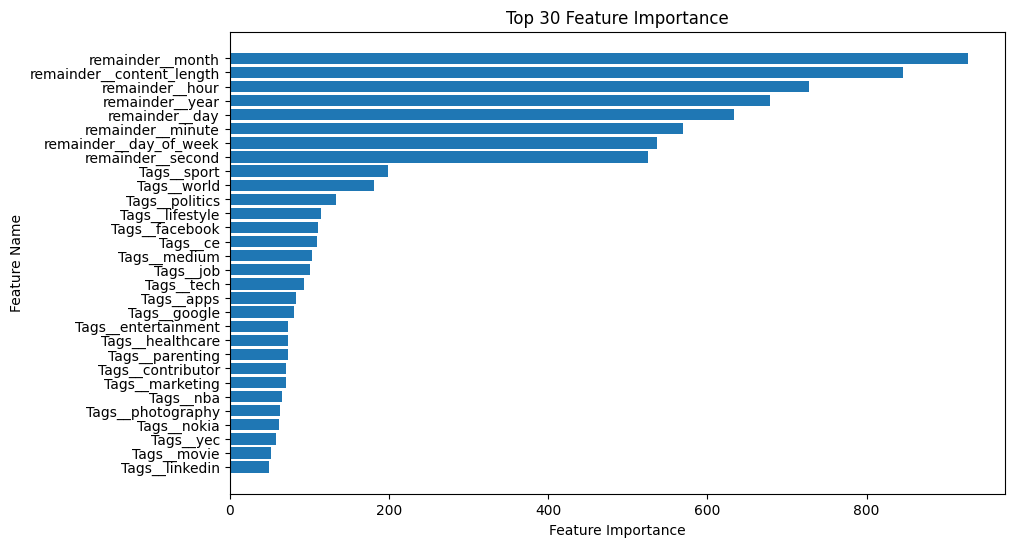

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt

lgbm_model = lgbm.named_steps['clf']
importance = lgbm_model.feature_importances_
feature_names = lgbm.named_steps['transformer'].get_feature_names_out()
importance_data = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)

print("Top 30 important features:")
for feature, imp in importance_data[:30]:
    print(f"{feature}: {imp}")

plt.figure(figsize=(10, 6))
plt.barh([x[0] for x in importance_data[:30]], [x[1] for x in importance_data[:30]])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 30 Feature Importance')
plt.gca().invert_yaxis()
plt.show()

## 3-3. Final Voting Classifier

To further improve model performance, I implemented an ensemble method using a **Voting Classifier**. The models included in the ensemble are **LightGBM (LGBMClassifier)**, **CatBoost (CatBoostClassifier)**, **RandomForest (RandomForestClassifier)**

I used a **soft voting** strategy, which takes the average of predicted probabilities from all models.
  - **LightGBM**: Given a weight of 1, as it performed the best during individual model testing.
  - **CatBoost**: Assigned a weight of 0.15.
  - **RandomForest**: Assigned a weight of 0.05.


In [ ]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

lgbm_model = Pipeline([('transformer', transformer),
                       ('clf', LGBMClassifier(random_state=0, learning_rate=0.01, n_estimators=300))])

cat_model = Pipeline([('transformer', transformer),
                      ('clf', CatBoostClassifier(random_state=0, learning_rate=0.01, n_estimators=300, eval_metric='AUC'))])

rf_model = Pipeline([('transformer', transformer),
                     ('clf', RandomForestClassifier(n_estimators=300, random_state=0))])

voting = VotingClassifier(estimators=[('lgbm', lgbm_model), ('cat', cat_model), ('rf', rf_model)], voting='soft', weights=[1, 0.15, 0.05])
voting.fit(X_train, y_train)

In [74]:
y_pred = voting.predict_proba(X_test)[:, 1]
df_pred = pd.DataFrame({'Id': df_test['Id'], 'Popularity': y_pred})
df_pred.to_csv('111062117.csv', index=False)

## 4. Conclusion and Insights

### 4-1. Kaggle Competition Results
  - **Public Rank**: 20th with an AUC score of 0.59591.
  - **Private Rank**: 27th with an AUC score of 0.59411.

### 4-2. Importance of Model Selection
One key takeaway from the project was the significant impact of **model selection**. Initially, the Random Forest model provided decent results, but switching to **LightGBM** resulted in a noticeable improvement in the score and ranking. This highlights how crucial it is to experiment with different models to find the one that best suits the dataset.

### 4-3. Data Cleaning Challenges
Data cleaning proved to be a critical step in achieving a higher score. At one point, the model's performance plateaued at an AUC score of **0.585**. After many times attempts, I discovered that certain features, like multi-word phrases, needed to be joined with underscores (e.g., replacing spaces with `_`). This improved the tokenizer's effectiveness and boosted the model's performance.

### 4-4. Feature Selection Lessons
More features do not always lead to better performance. In fact, after removing certain features, the model's AUC score increased. This underscores the importance of **feature selection** and the need to focus on the most relevant and meaningful features rather than just including as many as possible.